In [1]:
# Packages
import pandas as pd 
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns 
from random import uniform
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn import preprocessing 
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
import random
import warnings 
warnings.filterwarnings('ignore')

# Grain setting guarantees the reproductibility of results
np.random.seed(123) 

# Loading data
data = pd.read_csv('german_credit_data_dataset.csv')
data = pd.DataFrame(data)
data.head()


,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,customer_type
0,A11,6,A34,A43,1169.0,A65,A75,4.0,A93,A101,...,A121,67.0,A143,A152,2.0,A173,1,A192,A201,1
1,A12,48,A32,A43,5951.0,A61,A73,2.0,A92,A101,...,A121,22.0,A143,A152,1.0,A173,1,A191,A201,2
2,A14,12,A34,A46,2096.0,A61,A74,2.0,A93,A101,...,A121,49.0,A143,A152,1.0,A172,2,A191,A201,1
3,A11,42,A32,A42,7882.0,A61,A74,2.0,A93,A103,...,A122,45.0,A143,A153,1.0,A173,2,A191,A201,1
4,A11,24,A33,A40,4870.0,A61,A73,3.0,A93,A101,...,A124,53.0,A143,A153,2.0,A173,2,A191,A201,2


In [2]:
# We will use Logistic-Regresion
# Splitting data to train and test set 
X_train, X_test, Y_train, Y_test = train_test_split(data.drop('customer_type', axis=1), data['customer_type'])

In [3]:
# Scaling numeric data 
minmax =preprocessing.StandardScaler(copy=False)
# Selecting only numeric columns 
num_cols = X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

# Fitting StandartScaler with data 
minmax.fit(X_train[num_cols]) 
# Training set scaling
X_train[num_cols]=minmax.transform(X_train[num_cols])
# and test set 
X_test[num_cols]=minmax.transform(X_test[num_cols])


In [4]:
# Encoding preparation
# Selecting columns with categorical variables to encode 


cols = data.select_dtypes(include = 'object').columns.values 

encoder = ce.TargetEncoder(data,cols=cols)

# Pipline preparation

basic_model= Pipeline([
   ('encoder',encoder),
    ('estimator',LogisticRegression(max_iter=200,random_state=123,
                                   multi_class='ovr',solver='saga'))
])


# Grid params search 
param_grid = {'estimator__C':[i/10 for i in range(1,51,1)],#Inverse of regularization strength
              'estimator__penalty':['l2','l1'],# Type of loss function 
              'estimator__class_weight':['balanced',None]# Type of class weight 
                                                    # None - Every class have weight 1 
                                                    # Auto Class weight calcultion
              
      }
# Preparing and fitting grid search 
cvr = GridSearchCV(basic_model,param_grid=param_grid,cv=5)
cvr.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('encoder',
                                        TargetEncoder(cols=array(['checking_account_status', 'credit_history', 'purpose', 'savings',
       'present_employment', 'personal', 'other_debtors', 'property',
       'other_installment_plans', 'housing', 'job', 'telephone',
       'foreign_worker'], dtype=object),
                                                      drop_invariant=False,
                                                      handle_missi...
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'estimator__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,
                                          1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1,
                                          2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
             

In [5]:
# Basic model result
print(f"Score: {cvr.best_score_}")
cvr.best_params_

Score: 0.7573333333333334


{'estimator__C': 2.0,
 'estimator__class_weight': None,
 'estimator__penalty': 'l2'}

In [6]:
# Not really bad but can be much better 

In [7]:
# Another type of encoder 
onehot = ce.OneHotEncoder(data,cols=cols)
onehot_model = Pipeline([
   ('encoder',onehot),
    ('estimator',LogisticRegression(max_iter=200,random_state=123,
                                   multi_class='ovr',solver='saga'))
])
# I will do in the same way as previous 
cvr_oh = GridSearchCV(onehot_model,param_grid=param_grid,cv=5)
cvr_oh.fit(X_train,Y_train)
print(f"Score: {cvr_oh.best_score_}")
# Slightly better result, but looking for params takes much longer 
cvr_oh.best_params_

Score: 0.764


{'estimator__C': 0.1,
 'estimator__class_weight': None,
 'estimator__penalty': 'l2'}

For next test i will be using panlty='l2' becous its selecet by gridsearch.
I will try use only most importent feature. 

In [8]:
# Pipline preparation
most_imp = Pipeline([  ('encoder',encoder),
                    ('k_best',SelectFromModel(LogisticRegression(max_iter=200,random_state=123,
                                   multi_class='ovr',solver='saga'))),
                    ('estimator',LogisticRegression(max_iter=200,random_state=123,
                                   multi_class='ovr',solver='saga'))])

# Grid preparation
grid = {'estimator__C':[i/10 for i in range(1,51,3)],
        'k_best__max_features':[i for i in range(5,22)]} #number of selected feature
        
# cv 
cv_k = GridSearchCV(most_imp,grid,cv=5)
cv_k.fit(X_train,Y_train)

print(f"Score: {cv_k.best_score_}")
cv_k.best_params_

Score: 0.748


{'estimator__C': 1.9, 'k_best__max_features': 7}

As we can see it wasn't good approach. Now i will try using more thaneone logistic regression classifier.

In [9]:
estimators = [
    ('1',basic_model.set_params(estimator__C=2.0)),
    ('2',onehot_model.set_params(estimator__C=1.0)),
    ('3',most_imp.set_params(estimator__C=1.9,k_best__max_features=7))
]
# CV to compute score
final_model = VotingClassifier(estimators=estimators, voting='soft')
print(f"Score :{cross_val_score(final_model,X_train,Y_train,cv=4)}")

Score :[0.7712766  0.7712766  0.75935829 0.72192513]


As we can see all classifier achieved similar result, for the next test i will use final_model. From now on I will use test set to compute metrics. 

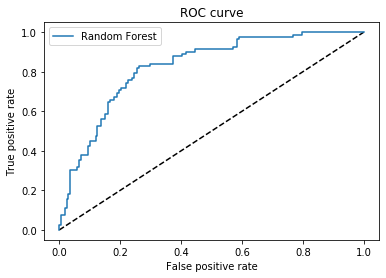

In [10]:
# ROC Curve 
final_model.fit(X_train,Y_train)

predict_proba1 = final_model.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, predict_proba1, pos_label=2) # false & true positive rates
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [11]:
# AUC metric
metrics.auc(fpr1, tpr1)

0.82585656213705